## Run this notebook

You can launch this notebook in the US GHG Center JupyterHub by clicking the link below.

[Launch in the US GHG Center JupyterHub (requires access)](https://hub.ghg.center/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FUS-GHG-Center%2Fghgc-docs&urlpath=lab%2Ftree%2Fghgc-docs%2Fuser_data_notebooks%2Foco2geos-co2-daygrid-v10r_User_Notebook.ipynb&branch=main)
   

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the OCO-2 GEOS Column CO₂ Concentrations data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.

   

## About the Data

In July 2014, NASA successfully launched the first dedicated Earth remote sensing satellite to study atmospheric carbon dioxide (CO₂) from space. The Orbiting Carbon Observatory-2 (OCO-2) is an exploratory science mission designed to collect space-based global measurements of atmospheric CO₂ with the precision, resolution, and coverage needed to characterize sources and sinks (fluxes) on regional scales (≥1000 km). This dataset provides global gridded, daily column-averaged carbon dioxide (XCO₂) concentrations from January 1, 2015 - February 28, 2022. The data are derived from OCO-2 observations that were input to the Goddard Earth Observing System (GEOS) Constituent Data Assimilation System (CoDAS), a modeling and data assimilation system maintained by NASA’s Global Modeling and Assimilation Office (GMAO). Concentrations are measured in moles of carbon dioxide per mole of dry air (mol CO₂/mol dry) at a spatial resolution of 0.5° x 0.625°. Data assimilation synthesizes simulations and observations, adjusting modeled atmospheric constituents like CO₂ to reflect observed values. With the support of NASA’s Carbon Monitoring System (CMS) Program and the OCO Science Team, this dataset was produced as part of the OCO-2 mission which provides the highest quality space-based XCO₂ retrievals to date.

For more information regarding this dataset, please visit the [OCO-2 GEOS Column CO₂ Concentrations](https://earth.gov/ghgcenter/data-catalog/oco2geos-co2-daygrid-v10r) data overview page.

## Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

## Querying the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in STAC collection.
# Name of the collection for OCO-2 GEOS Column CO₂ Concentrations. 
collection_name = "oco2geos-co2-daygrid-v10r"

In [3]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'oco2geos-co2-daygrid-v10r',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r'}],
 'title': 'OCO-2 GEOS Column CO₂ Concentrations v10r',
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['2015-01-01T00:00:00+00:00',
     '2022-02-28T00:00:00+00:00']]}},
 'license': 'CC0-1.0',
 'renders': {'xco2': {'assets': ['xco2'],
   'nodata': 0,
   'rescale': [[412, 422]],
   'colormap_name': 'magma'},
  'dashboard': {'assets': ['xco2'],
   'nodata': 0,
   'rescale': [[412, 422]],
 

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2015 to February 2022. By looking at the `dashboard:time density`, we can see that these observations are collected daily.

In [4]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [6]:
# Check total number of items available
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")

Found 2615 items


In [7]:
# Examining the first item in the collection
items[0]

{'id': 'oco2geos-co2-daygrid-v10r-20220228',
 'bbox': [-180.3125, -90.25, 179.6875, 90.25],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220228'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220228/map?assets=xco2&nodata=0&rescale=412%2C422&colormap_name=magma',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets': {'xco2': {'href': 's3://ghg

Below, we enter minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in Column-Averaged XCO₂ Concentrations Levels Using the Raster API

In this notebook, we will explore the temporal impacts of CO₂ emissions. We will visualize the outputs on a map using `folium.`

In [8]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"]: item for item in items} 
asset_name = "xco2" #fossil fuel

In [9]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for 2022-02-08 and again for 2022-01-27, so that we can visualize each event independently.

In [10]:
color_map = "magma"
oco2_1 = requests.get(
    f"{RASTER_API_URL}/collections/{items[list(items.keys())[0]]['collection']}/items/{items[list(items.keys())[0]]['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
oco2_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220228/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=411.7429234611336%2C423.60419320175424'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

In [11]:
oco2_2 = requests.get(
    f"{RASTER_API_URL}/collections/{items[list(items.keys())[1]]['collection']}/items/{items[list(items.keys())[1]]['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
oco2_2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220227/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=411.7429234611336%2C423.60419320175424'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

## Visualizing Daily Column-Averaged XCO₂ Concentrations

In [12]:
# Set initial zoom and center of map for XCO₂ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


map_layer_2020 = TileLayer(
    tiles=oco2_1["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2020.add_to(map_.m1)

map_layer_2019 = TileLayer(
    tiles=oco2_2["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2019.add_to(map_.m2)

# visualising the map
map_

# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Akoeman (Cameroon).

In [13]:
# B

china_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [115, 39],   # Punto 1 (Esquina noreste)
                [115, 41],   # Punto 2 (Esquina noroeste)
                [113, 41],   # Punto 3 (Esquina suroeste)
                [113, 39],   # Punto 4 (Esquina sureste)
                [115, 39]    # Regresa al Punto 1
            ]
        ],
        "type": "Polygon",
    },
}

russia_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [100, 61],   # Punto 1 (Esquina noreste)
                [100, 70],   # Punto 2 (Esquina noroeste)
                [90, 70],    # Punto 3 (Esquina suroeste)
                [90, 61],    # Punto 4 (Esquina sureste)
                [100, 61]    # Regresa al Punto 1
            ]
        ],
        "type": "Polygon",
    },
}

cameroon_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [12, 3],  # Punto 1 (Esquina noreste)
                [12, 5],  # Punto 2 (Esquina noroeste)
                [10, 5],  # Punto 3 (Esquina suroeste)
                [10, 3],  # Punto 4 (Esquina sureste)
                [12, 3]   # Regresa al Punto 1
            ]
        ],
        "type": "Polygon",
    },
}


In [14]:
# We will plug in the coordinates for a location inside the the polygon and a zoom level
aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(china_aoi, name="Fangshang, Beijing").add_to(aoi_map)
folium.GeoJson(russia_aoi, name="Krasnoyarsk Krai, East Siberia").add_to(aoi_map)
folium.GeoJson(cameroon_aoi, name="Akoeman, Cameroon").add_to(aoi_map)
aoi_map

In [15]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 600 items


In [16]:
# Explore the first item
items[0]

{'id': 'oco2geos-co2-daygrid-v10r-20220228',
 'bbox': [-180.3125, -90.25, 179.6875, 90.25],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220228'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220228/map?assets=xco2&nodata=0&rescale=412%2C422&colormap_name=magma',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets': {'xco2': {'href': 's3://ghg

In [17]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

In [18]:
for item in items:
    print(item["properties"]["datetime"])
    break

2022-02-28T00:00:00+00:00


With the function above we can generate the statistics for the AOI.

In [19]:
%%time
stats_china = [generate_stats(item, china_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[115.0, 39.0], [115.0, 41.0], [113.0, 41.0], [113.0, 39.0], [115.0, 39.0]]]}, 'properties': {'statistics': {'b1': {'min': 418.56263487716205, 'max': 420.10965626104735, 'mean': 419.04829880615455, 'count': 12.80000114440918, 'sum': 5363.818704281498, 'std': 0.28168216307237665, 'median': 419.0171202935744, 'majority': 418.56263487716205, 'minority': 418.56263487716205, 'unique': 20.0, 'histogram': [[3.0, 4.0, 4.0, 3.0, 2.0, 3.0, 0.0, 0.0, 0.0, 1.0], [418.56263487716205, 418.7173370155506, 418.8720391539391, 419.02674129232764, 419.1814434307162, 419.3361455691047, 419.49084770749323, 419.64554984588176, 419.8002519842703, 419.9549541226588, 420.10965626104735]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 20.0, 'percentile_2': 418.56263487716205, 'percentile_98': 419.49006117647514}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[115.0, 39.0], [115.0, 41.0], [113.0, 41.0], [1

In [21]:
%%time
stats_russia = [generate_stats(item, russia_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[100.0, 61.0], [100.0, 70.0], [90.0, 70.0], [90.0, 61.0], [100.0, 61.0]]]}, 'properties': {'statistics': {'b1': {'min': 420.05152499768883, 'max': 422.7317222103011, 'mean': 421.10357589485324, 'count': 288.0, 'sum': 121277.82985771773, 'std': 0.6141049862059238, 'median': 421.0425140627195, 'majority': 420.05152499768883, 'minority': 420.05152499768883, 'unique': 323.0, 'histogram': [[33.0, 39.0, 47.0, 71.0, 44.0, 30.0, 21.0, 16.0, 12.0, 10.0], [420.05152499768883, 420.31954471895006, 420.5875644402113, 420.8555841614725, 421.12360388273373, 421.39162360399496, 421.6596433252562, 421.9276630465174, 422.19568276777864, 422.46370248903986, 422.7317222103011]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 323.0, 'percentile_2': 420.1527772238478, 'percentile_98': 422.50003752997145}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[100.0, 61.0], [100.0, 70.0], [90.0, 70.0], [90.0,

In [24]:
%%time
stats_cameroon = [generate_stats(item, cameroon_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[12.0, 3.0], [12.0, 5.0], [10.0, 5.0], [10.0, 3.0], [12.0, 3.0]]]}, 'properties': {'statistics': {'b1': {'min': 419.9793474981561, 'max': 421.0884289932437, 'mean': 420.5080224595866, 'count': 12.80000114440918, 'sum': 5382.503168715949, 'std': 0.25002207381905, 'median': 420.405271142954, 'majority': 419.9793474981561, 'minority': 419.9793474981561, 'unique': 20.0, 'histogram': [[1.0, 0.0, 5.0, 5.0, 1.0, 2.0, 3.0, 0.0, 1.0, 2.0], [419.9793474981561, 420.09025564766483, 420.2011637971736, 420.31207194668235, 420.4229800961911, 420.5338882456999, 420.6447963952087, 420.75570454471745, 420.8666126942262, 420.97752084373496, 421.0884289932437]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 20.0, 'percentile_2': 420.2132695354521, 'percentile_98': 421.0884289932437}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[12.0, 3.0], [12.0, 5.0], [10.0, 5.0], [10.0, 3.0], [12.0, 3.0]]]}, '

SSLError: HTTPSConnectionPool(host='earth.gov', port=443): Max retries exceeded with url: /ghgcenter/api/raster/cog/statistics?url=s3%3A%2F%2Fghgc-data-store%2Foco2geos-co2-daygrid-v10r%2Foco2_GEOS_XCO2_L3CO2_day_B10206Ar_20210914.tif (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:997)')))

In [26]:
stats_china[0]
stats_russia[0]
# stats_cameroon[0]

{'statistics': {'b1': {'min': 420.05152499768883,
   'max': 422.7317222103011,
   'mean': 421.10357589485324,
   'count': 288.0,
   'sum': 121277.82985771773,
   'std': 0.6141049862059238,
   'median': 421.0425140627195,
   'majority': 420.05152499768883,
   'minority': 420.05152499768883,
   'unique': 323.0,
   'histogram': [[33.0, 39.0, 47.0, 71.0, 44.0, 30.0, 21.0, 16.0, 12.0, 10.0],
    [420.05152499768883,
     420.31954471895006,
     420.5875644402113,
     420.8555841614725,
     421.12360388273373,
     421.39162360399496,
     421.6596433252562,
     421.9276630465174,
     422.19568276777864,
     422.46370248903986,
     422.7317222103011]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 323.0,
   'percentile_2': 420.1527772238478,
   'percentile_98': 422.50003752997145}},
 'datetime': '2022-02-28T00:00:00+00:00'}

In [27]:
def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df_china = clean_stats(stats_china)
df_russia = clean_stats(stats_russia)
df_china.head(5)
df_russia.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2022-02-28T00:00:00+00:00,420.051525,422.731722,421.103576,288.0,121277.829858,0.614105,421.042514,420.051525,420.051525,323.0,"[[33.0, 39.0, 47.0, 71.0, 44.0, 30.0, 21.0, 16...",100.0,0.0,323.0,420.152777,422.500038,2022-02-28 00:00:00+00:00
1,2022-02-27T00:00:00+00:00,419.864162,421.329798,420.661540,288.0,121150.523523,0.337096,420.656153,419.864162,419.864162,323.0,"[[9.0, 16.0, 14.0, 55.0, 42.0, 59.0, 39.0, 27....",100.0,0.0,323.0,419.982931,421.266908,2022-02-27 00:00:00+00:00
2,2022-02-26T00:00:00+00:00,419.934331,421.333971,420.788223,288.0,121187.008153,0.321016,420.854900,419.934331,419.934331,323.0,"[[15.0, 15.0, 10.0, 11.0, 38.0, 42.0, 65.0, 58...",100.0,0.0,323.0,419.984597,421.265060,2022-02-26 00:00:00+00:00
3,2022-02-25T00:00:00+00:00,419.675631,421.165765,420.596004,288.0,121131.649215,0.336212,420.677356,419.675631,419.675631,323.0,"[[11.0, 15.0, 23.0, 10.0, 15.0, 48.0, 66.0, 66...",100.0,0.0,323.0,419.774904,421.078377,2022-02-25 00:00:00+00:00
4,2022-02-24T00:00:00+00:00,419.092954,421.184399,420.393972,288.0,121073.463946,0.611359,420.582819,419.092954,419.092954,323.0,"[[15.0, 27.0, 26.0, 19.0, 19.0, 28.0, 24.0, 30...",100.0,0.0,323.0,419.217413,421.121498,2022-02-24 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the XCO₂ concentrations time series (January 1, 2015 - February 28, 2022) available for the Dallas, Cameroon area of the U.S. We can plot the data set using the code below:

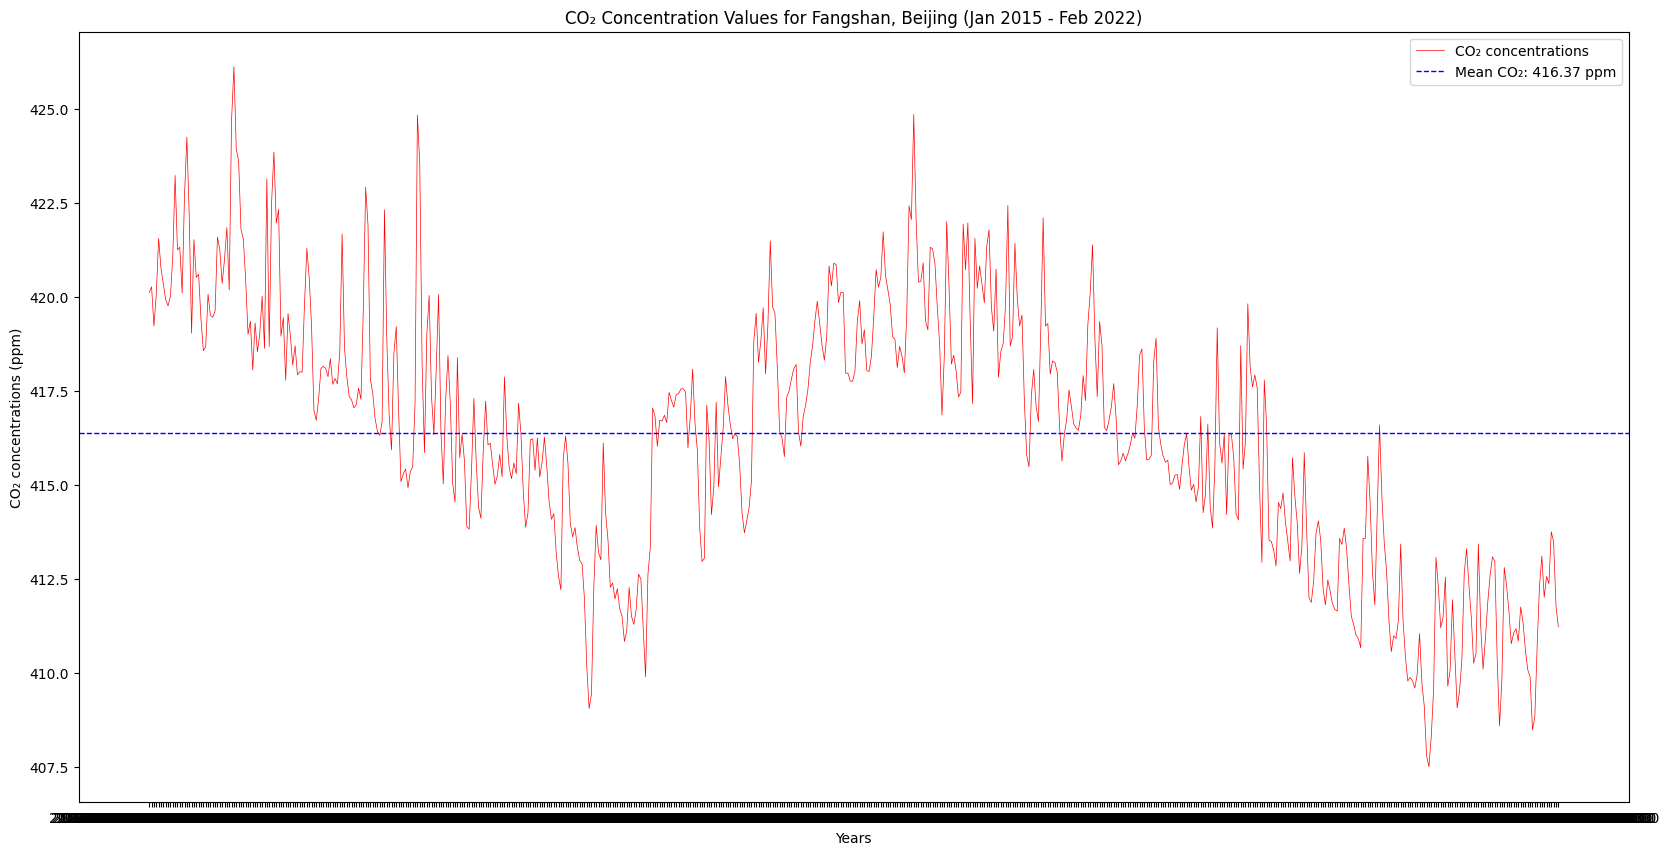

In [29]:
import matplotlib.pyplot as plt

# Suponiendo que 'df' es tu DataFrame y ya has importado pandas y matplotlib

# Calcular la media de las concentraciones de CO₂
mean_co2 = df_china["max"].mean()

fig = plt.figure(figsize=(20, 10))

plt.plot(
    df_china["datetime"],
    df_china["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="CO₂ concentrations",
)

# Añadir la línea de la media
plt.axhline(mean_co2, color="blue", linestyle="--", linewidth=1, label=f"Mean CO₂: {mean_co2:.2f} ppm")

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO₂ concentrations (ppm)")
plt.title("CO₂ Concentration Values for Fangshan, Beijing (Jan 2015 - Feb 2022)")

plt.show()


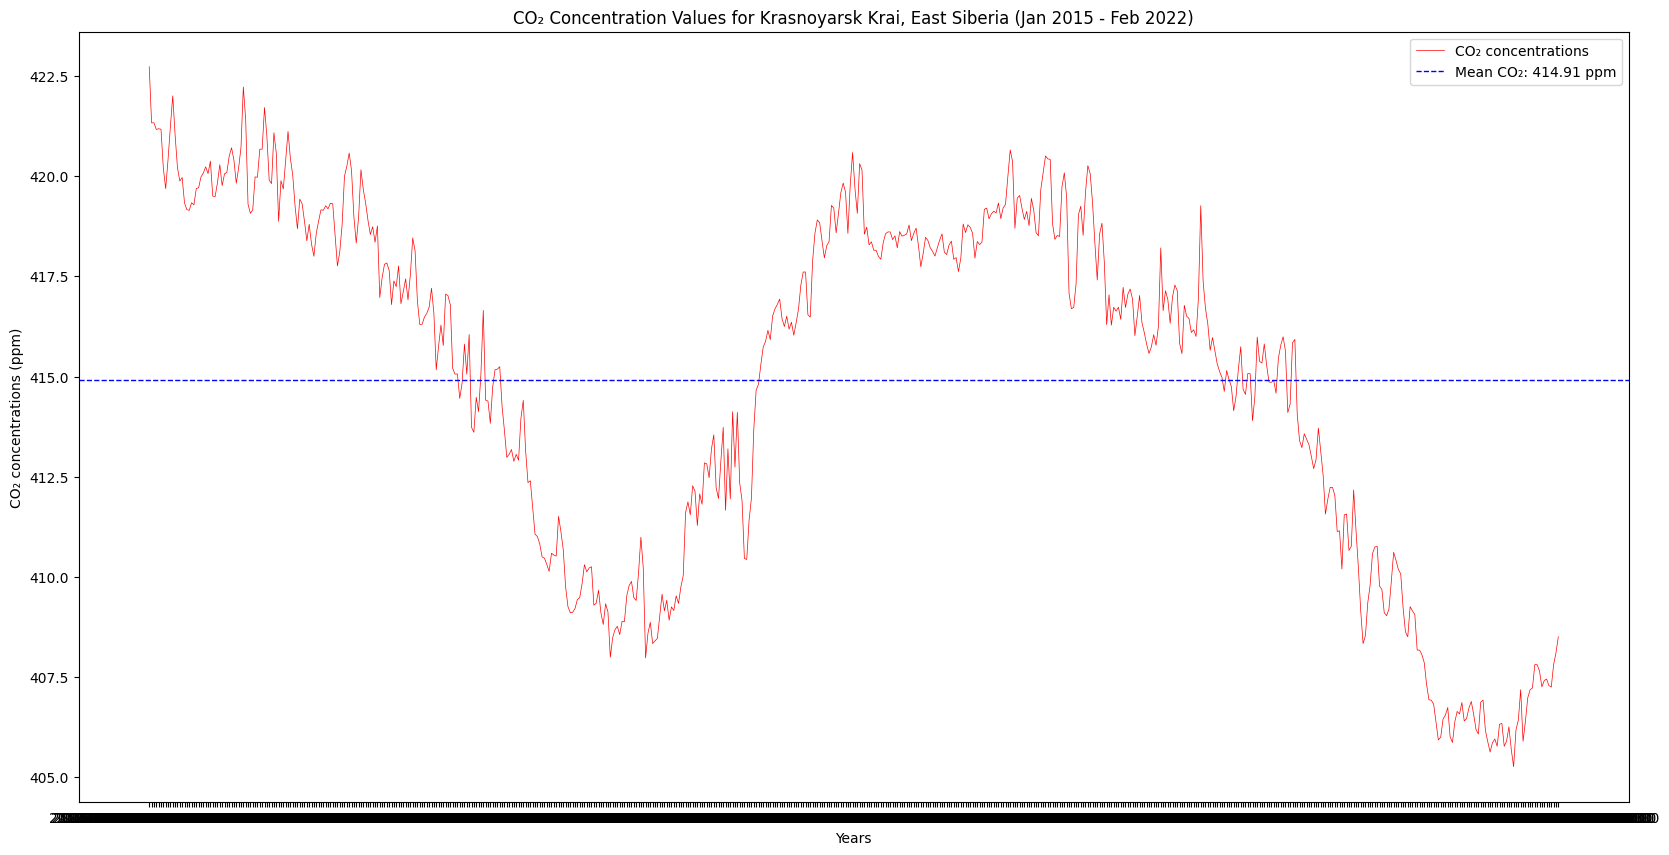

In [30]:
import matplotlib.pyplot as plt

# Suponiendo que 'df' es tu DataFrame y ya has importado pandas y matplotlib

# Calcular la media de las concentraciones de CO₂
mean_co2 = df_russia["max"].mean()

fig = plt.figure(figsize=(20, 10))

plt.plot(
    df_russia["datetime"],
    df_russia["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="CO₂ concentrations",
)

# Añadir la línea de la media
plt.axhline(mean_co2, color="blue", linestyle="--", linewidth=1, label=f"Mean CO₂: {mean_co2:.2f} ppm")

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO₂ concentrations (ppm)")
plt.title("CO₂ Concentration Values for Krasnoyarsk Krai, East Siberia (Jan 2015 - Feb 2022)")

plt.show()


In [31]:
print(items[2]["properties"]["datetime"])

2022-02-26T00:00:00+00:00


In [32]:
oco2_3 = requests.get(
    f"{RASTER_API_URL}/collections/{items[2]['collection']}/items/{items[2]['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
oco2_3

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220226/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=411.7429234611336%2C423.60419320175424'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

In [33]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6.8,
)

map_layer = TileLayer(
    tiles=oco2_3["tiles"][0],
    attr="GHG", opacity = 0.7
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook, we have successfully explored, analyzed, and visualized the STAC collection for OCO-2 GEOS Column CO₂ Concentrations.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the Column-Averaged XCO₂ Concentrations Levels for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Visualizing the Data as a Time Series


If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).